In [2]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pyEX as p
import math
from itertools import islice

In [3]:
#set up client
from sandboxToken import iexSandboxToken
c = p.Client(api_token=iexSandboxToken, version='sandbox')

In [4]:
#Import closing for TSLA
ticker = 'TLSA'
tempLoad = c.chart(symbol=ticker, timeframe='max')

my_columns = ['date', 'close']
tslaDf = pd.DataFrame(columns=my_columns)
tslaDf = tslaDf.append(tempLoad, ignore_index=True)
tslaDf = tslaDf[['date', 'close']]

print(tslaDf.head())

         date  close
0  2021-03-19   3.12
1  2021-03-18   3.08
2  2021-03-17   3.26
3  2021-03-16   3.31
4  2021-03-15   3.15


In [5]:
#add new columns for sma
#note, the below SMAs require a min value in the window as 1
#I could change the min_periods parameter to equal the window for a traditional moving average
tslaDf['20_SMA'] = tslaDf['close'].rolling(window=20, min_periods=20).mean()
tslaDf['50_SMA'] = tslaDf['close'].rolling(window=50, min_periods=50).mean()
tslaDf = tslaDf.sort_values(by='date', ascending=True)
#tslaDf = tslaDf.set_index('date')

print(tslaDf.head(20))

           date   close    20_SMA    50_SMA
541  2018-11-20  1.6700  1.713845  1.497486
540  2018-11-21  2.1490  1.710775  1.488086
539  2018-11-23  1.9600  1.676740  1.468666
538  2018-11-26  1.7346  1.654240  1.453926
537  2018-11-27  1.8480  1.642615  1.439234
536  2018-11-28  1.8610  1.619215  1.425274
535  2018-11-29  1.7073  1.604165  1.410654
534  2018-11-30  1.6200  1.591300  1.398108
533  2018-12-03  1.6970  1.580300  1.385708
532  2018-12-04  1.7000  1.564950  1.375768
531  2018-12-06  1.7010  1.549950  1.366608
530  2018-12-07  1.6000  1.534900  1.356588
529  2018-12-10  1.4460  1.524050  1.348328
528  2018-12-11  1.6376  1.519050  1.344008
527  2018-12-12  1.6900  1.508670  1.333256
526  2018-12-13  1.8333  1.490265  1.322676
525  2018-12-14  1.6000  1.456890  1.314660
524  2018-12-17  1.5321  1.438790  1.313660
523  2018-12-18  1.6900  1.430185  1.312962
522  2018-12-19  1.6000  1.415685  1.308482


In [6]:
#add a column for Signal
#boolean
#if 20 day SMA crosses (exceeds) 50 days SMA, thats a buy
#if 20 day SMA becomes less than 50 day SMA, thats a sell

tslaDf['Signal'] = 0.0
tslaDf['Signal'] = np.where(tslaDf['20_SMA'] > tslaDf['50_SMA'], 1.0, 0.0)

In [7]:
#add another column for position
#this will calculate the difference in signal value to determine if a buy or sell trigger occurs

tslaDf['Position'] = tslaDf['Signal'].diff()

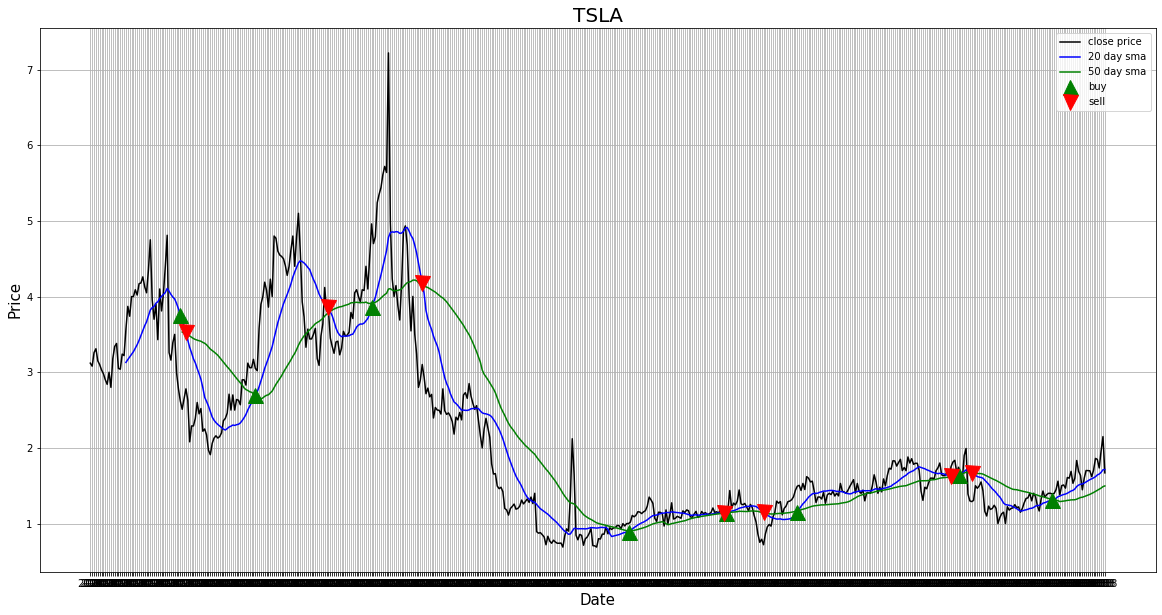

In [8]:
#plot
plt.figure(figsize=(20,10))
tslaDf['close'].plot(color='k', label='close price')
tslaDf['20_SMA'].plot(color='b', label='20 day sma')
tslaDf['50_SMA'].plot(color='g', label='50 day sma')

plt.plot()

#plot buy signals
plt.plot(tslaDf[tslaDf['Position'] == -1].index, 
         tslaDf['20_SMA'][tslaDf['Position'] == -1], 
         '^', markersize = 15, color = 'g', label = 'buy')

#plot sell signals
# plot ‘sell’ signals
plt.plot(tslaDf[tslaDf['Position'] == 1].index, 
         tslaDf['20_SMA'][tslaDf['Position'] == 1], 
         'v', markersize = 15, color = 'r', label = 'sell')

tslaDf['year'] = pd.DatetimeIndex(tslaDf['date']).year
plt.xticks(tslaDf.index, tslaDf['year'].values)

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('TSLA', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [9]:
dca = 1000
startDate = '2010-02-03'
endDate = '2021-02-01'

#tslaDf.to_csv(r'C:\Users\...\tslaPrices.csv')

def sharesToBuyOrSell(df=tslaDf):
    my_columns = ['Date', 'Type', 'Number of Shares Bought/Sold', 'Price', 'Total Shares', 'Net Change', 'Cost Basis', 'P/L', 'Market Value']
    bookDf = pd.DataFrame(columns=my_columns)
    #drop any values in the TSLA df that are outside the defined range
    df = df.loc[(df.date <= endDate) & (df.date >= startDate)]
    #tslaDf = tslaDf[tslaDf.date < endDate]
    #tslaDf = tslaDf[tslaDf.date > startDate]
    #df.to_csv(r'C:\Users\...\tslaPrices.csv')
    for index, row in df.iterrows():
        #print(row['Position'])
        if row['Position'] == 1:
            #print(row['date'])
            bookDf = bookDf.append(pd.Series([row['date'],
                                'Buy',
                                math.floor(dca/row['close']), 
                                row['close'], 0, 0, 0, 0, 0], index = my_columns), ignore_index=True)
        if row['Position'] == -1:
            #print(row['date'])
            bookDf = bookDf.append(pd.Series([row['date'],
                                'Sell',
                                math.floor(dca/row['close']), 
                                row['close'], 0, 0, 0, 0, 0], index = my_columns), ignore_index=True)
    
    if bookDf.loc[0, 'Type'] == 'Sell':
        bookDf.loc[0, 'Total Shares'] = 0
    else:
        bookDf.loc[0, 'Total Shares'] = bookDf.loc[0, 'Number of Shares Bought/Sold']
        bookDf.loc[0, 'Net Change'] = bookDf.loc[0, 'Price']*bookDf.loc[0, 'Number of Shares Bought/Sold']
    
    #for index, row in bookDf[:1].iterrows():
     #   if row['Type'] == 'Sell':
      #      if row['Total Shares'].shift() - row['Number of Shares Bought/Sold'] < 0:
       #         bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
        #        bookDf.loc[i, 'Total Shares'] = 0
         #       bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price'] 
        
    for i in range(1, len(bookDf['Date'])):        
        if bookDf.loc[i, 'Type'] == 'Sell':
            if bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold'] < 0:
                bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
                bookDf.loc[i, 'Total Shares'] = 0
                bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
            else:
                bookDf.loc[i, 'Total Shares'] = bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold']
                bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
            #if bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold'] < 0:
             #   bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
              #  bookDf.loc[i, 'Total Shares'] = 0
              #  bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
        else:
            bookDf.loc[i, 'Total Shares'] = bookDf.loc[i, 'Number of Shares Bought/Sold'] + bookDf.loc[i-1, 'Total Shares']
            bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
        
    return bookDf

    #bookDf.to_csv(r'C:\Users\...\bookValues.csv')
    
sharesToBuyOrSell()
    
            

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,Cost Basis,P/L,Market Value
0,2019-01-07,Sell,719,1.3900,0,0,0,0,0
1,2019-04-11,Buy,775,1.2900,775,999.75,0,0,0
2,2019-05-01,Sell,573,1.7440,202,999.312,0,0,0
3,2019-05-07,Buy,570,1.7539,772,999.723,0,0,0
4,2019-09-16,Sell,669,1.4940,103,999.486,0,0,0
5,2019-10-10,Buy,1388,0.7200,1491,999.36,0,0,0
6,2019-11-07,Sell,861,1.1610,630,999.621,0,0,0
7,2019-11-08,Buy,841,1.1890,1471,999.949,0,0,0
8,2020-01-29,Sell,1000,1.0000,471,1000,0,0,0
9,2020-07-07,Buy,322,3.1020,793,998.844,0,0,0


In [10]:
def totalShareTally():
    #define variable values at index 0
    bookDf = sharesToBuyOrSell()
    '''
    df = bookDf
    df['Adjusted Quantity'] = df.apply(lambda x: ((x['Number of Shares Bought/Sold'] > 0 - (x['Number of Shares Bought/Sold'] < 0)) * x['Quantity'], axis = 1)
    df['Adjusted Quantity'] = df['Adjusted Quantity'].cumsum()
    df['Adjusted Price Per Unit'] = df.apply(lambda x: ((x.Number of Shares Bought/Sold > 0) - (x.Number of Shares Bought/Sold < 0)) * x['Net Change'], axis = 1)
    df['Adjusted Price Per Unit'] = df['Adjusted Price Per Unit'].cumsum().div(df['Adjusted Quantity'])
    
    df.loc[df['Number of Shares Bought/Sold'] < 0,['Adjusted Price Per Unit']] = np.NaN
    df.fillna(method='ffill', inplace=True)
    return(df)
    '''
    
    
    df1 = (bookDf.copy()[bookDf['Type'] == 'Buy'].assign(CumAmountBuy = bookDf['Net Change'].cumsum()).assign(CumQtyBuy = bookDf['Number of Shares Bought/Sold'].cumsum()))
    df2 = pd.merge(bookDf, df1, how='left', on=['Date', 'Type', 'Number of Shares Bought/Sold', 'Price', 'Total Shares', 'Net Change', 'Cost Basis', 'P/L', 'Market Value']).ffill()
    #df2 = df2.fillna(0)
    s = df2['CumAmountBuy'] / df2['CumQtyBuy']
    s = s.fillna(0)
    df2['Average Cost'] = np.select([((df2['Type'] == 'Buy') & (df2['Type'].shift() == 'Sell')),
                         (df2['Type'] == 'Sell')],
                       [((df2['Number of Shares Bought/Sold'] * df2['Price'] + df2['Total Shares'].shift() * s.shift()) / df2['Total Shares']),
                        np.nan],
                       s)
    df2['Average Cost'] = round(df2['Average Cost'],3).ffill()
    #df2 = df2.drop(['Cost Basis', 'Market Value', 'CumQtyBuy', 'CumAmountBuy'], axis=1)
    #print(s)
    #return df1
    return df2

    
    
totalShareTally()
        
    

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,Cost Basis,P/L,Market Value,CumAmountBuy,CumQtyBuy,Average Cost
0,2019-01-07,Sell,719,1.3900,0,0.000,0,0,0,NaN,NaN,NaN
1,2019-04-11,Buy,775,1.2900,775,999.750,0,0,0,999.750,1494.0,1.290
2,2019-05-01,Sell,573,1.7440,202,999.312,0,0,0,999.750,1494.0,1.290
3,2019-05-07,Buy,570,1.7539,772,999.723,0,0,0,2998.785,2637.0,1.470
4,2019-09-16,Sell,669,1.4940,103,999.486,0,0,0,2998.785,2637.0,1.470
5,2019-10-10,Buy,1388,0.7200,1491,999.360,0,0,0,4997.631,4694.0,0.749
6,2019-11-07,Sell,861,1.1610,630,999.621,0,0,0,4997.631,4694.0,0.749
7,2019-11-08,Buy,841,1.1890,1471,999.949,0,0,0,6997.201,6396.0,1.136
8,2020-01-29,Sell,1000,1.0000,471,1000.000,0,0,0,6997.201,6396.0,1.136
9,2020-07-07,Buy,322,3.1020,793,998.844,0,0,0,8996.045,7718.0,1.909


In [13]:
'''
Average Cost might still be dubious but I'll move on...

Calculating P/L is just the difference between the previous row's average cost and the row price, multiplied
by the number of shares sold. It only applies to sold shares

Not gonna bother with market value
'''

def calcPL():
    df2 = totalShareTally()
    #skip the first row since sale cannot occur, no P/L
    df2 = df2.drop(columns=['Cost Basis', 'Market Value'])
    for index, row in df2.iterrows():
        if row['Type'] == 'Sell':
            try:
                df2.loc[index, 'P/L'] = (row['Price']-df2.loc[index-1, 'Average Cost'])*row['Number of Shares Bought/Sold']
            except:
                pass
    return df2
calcPL()

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,P/L,CumAmountBuy,CumQtyBuy,Average Cost
0,2019-01-07,Sell,719,1.3900,0,0.000,0.000,NaN,NaN,NaN
1,2019-04-11,Buy,775,1.2900,775,999.750,0.000,999.750,1494.0,1.290
2,2019-05-01,Sell,573,1.7440,202,999.312,260.142,999.750,1494.0,1.290
3,2019-05-07,Buy,570,1.7539,772,999.723,0.000,2998.785,2637.0,1.470
4,2019-09-16,Sell,669,1.4940,103,999.486,16.056,2998.785,2637.0,1.470
5,2019-10-10,Buy,1388,0.7200,1491,999.360,0.000,4997.631,4694.0,0.749
6,2019-11-07,Sell,861,1.1610,630,999.621,354.732,4997.631,4694.0,0.749
7,2019-11-08,Buy,841,1.1890,1471,999.949,0.000,6997.201,6396.0,1.136
8,2020-01-29,Sell,1000,1.0000,471,1000.000,-136.000,6997.201,6396.0,1.136
9,2020-07-07,Buy,322,3.1020,793,998.844,0.000,8996.045,7718.0,1.909


In [16]:
'''
Create a new function that just returns the net profit for running the MA strategy
'''
def totalProfit():
    df2 = calcPL()
    profit = sum(df2['P/L'])
    profit = "${:,.2f}". format(profit)
    print(profit)
    
totalProfit()


$1,723.47
